In [2]:
# Prepare fake-factory library for the docker pyspark environment used 
# see: https://github.com/jupyter/docker-stacks/tree/master/pyspark-notebook

import os
os.environ['PYSPARK_PYTHON'] = 'python2'
os.environ['PATH'] = os.environ['PATH'].replace('/opt/conda/bin','/opt/conda/envs/python2/bin')
os.environ['CONDA_ENV_PATH'] = '/opt/conda/envs/python2'
!pip -q install fake-factory

In [14]:
# Prepare fake data to process

from datetime import datetime, timedelta
from faker import Faker
fake = Faker()
import pandas as pd

start = datetime.today()
end = start + timedelta(0.05)

d = [(str(fake.date_time_between_dates(start, end)), fake.ipv4(), fake.free_email_domain()) for x in range(500)]

In [4]:
# Import pyspark 
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F

# Start a SparkContext, SQLContext
sc = SparkContext('local[*]')
sqlContext = SQLContext(sc)

# Import plotting libs
import seaborn as sns
%matplotlib inline

In [5]:
# Define the resample function, to perform resampling on timeseries columns

def resample(column, agg_interval=900, time_format='yyyy-MM-dd HH:mm:ss'):
    """
    Resamples specified time column of a Spark DataFrame to a specified interval. Interval is given in seconds.lllll
    
    Parameters
    ----------.
    column : Spark Column or string
    agg_interval : integer
    time_format : string
    
    >>> df = sqlContext.createDataFrame([("2016-01-20 13:32:05",),("2016-01-20 13:50:15",)], ['dt'])
    >>> df.select(resample('dt').alias('dt_resampled')).show()
    >>> +-------------------+
    >>> |       dt_resampled|
    >>> +-------------------+
    >>> |2016-01-20 13:30:00|
    >>> |2016-01-20 13:45:00|
    >>> +-------------------+
    
    Returns
    -------
    Spark Column
    """
    if type(column)==str:
        column = F.col(column)   
    col_ut =  F.unix_timestamp(column, format=time_format)       # convert to unix timestamp
    col_ut_agg =  F.floor(col_ut / agg_interval) * agg_interval  # divide the unix timestamp into intervals
    col_ts = F.from_unixtime(col_ut_agg)                         # convert unix timestamp into timestamp
    return col_ts

In [15]:
df = sqlContext.createDataFrame(d, ['dt','ip','email_provider'])
df.show(5)

+-------------------+---------------+--------------+
|                 dt|             ip|email_provider|
+-------------------+---------------+--------------+
|2016-01-20 17:08:24|  76.60.136.211|     yahoo.com|
|2016-01-20 17:01:05| 36.196.144.103|     gmail.com|
|2016-01-20 17:56:08| 33.243.151.184|   hotmail.com|
|2016-01-20 17:25:36|  174.92.55.167|   hotmail.com|
|2016-01-20 17:01:34|229.223.121.197|     gmail.com|
+-------------------+---------------+--------------+
only showing top 5 rows



In [16]:
df = df.withColumn('dt_resampled', resample(df.dt, 900))
df.show(5)

+-------------------+---------------+--------------+-------------------+
|                 dt|             ip|email_provider|       dt_resampled|
+-------------------+---------------+--------------+-------------------+
|2016-01-20 17:08:24|  76.60.136.211|     yahoo.com|2016-01-20 17:00:00|
|2016-01-20 17:01:05| 36.196.144.103|     gmail.com|2016-01-20 17:00:00|
|2016-01-20 17:56:08| 33.243.151.184|   hotmail.com|2016-01-20 17:45:00|
|2016-01-20 17:25:36|  174.92.55.167|   hotmail.com|2016-01-20 17:15:00|
|2016-01-20 17:01:34|229.223.121.197|     gmail.com|2016-01-20 17:00:00|
+-------------------+---------------+--------------+-------------------+
only showing top 5 rows



In [17]:
df_resampled = df.groupBy('dt_resampled', 'email_provider').count()
df_resampled.show(5)

+-------------------+--------------+-----+
|       dt_resampled|email_provider|count|
+-------------------+--------------+-----+
|2016-01-20 17:00:00|   hotmail.com|   34|
|2016-01-20 17:00:00|     gmail.com|   36|
|2016-01-20 17:15:00|   hotmail.com|   41|
|2016-01-20 17:15:00|     gmail.com|   29|
|2016-01-20 16:45:00|   hotmail.com|   22|
+-------------------+--------------+-----+
only showing top 5 rows



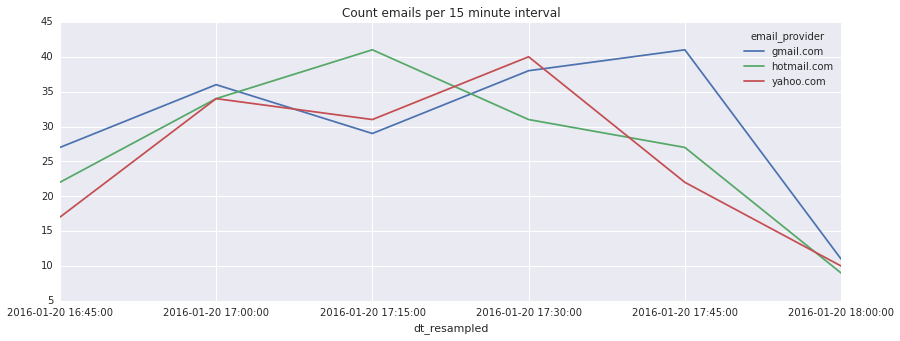

In [18]:
df_resampled.toPandas() \
    .pivot(index='dt_resampled', columns='email_provider', values='count') \
    .plot(figsize=[14,5], title='Count emails per 15 minute interval')